In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [131]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ids = test['id']
df = pd.concat([train, test])

In [132]:
df = df.drop(columns = ['id'])

In [133]:
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])

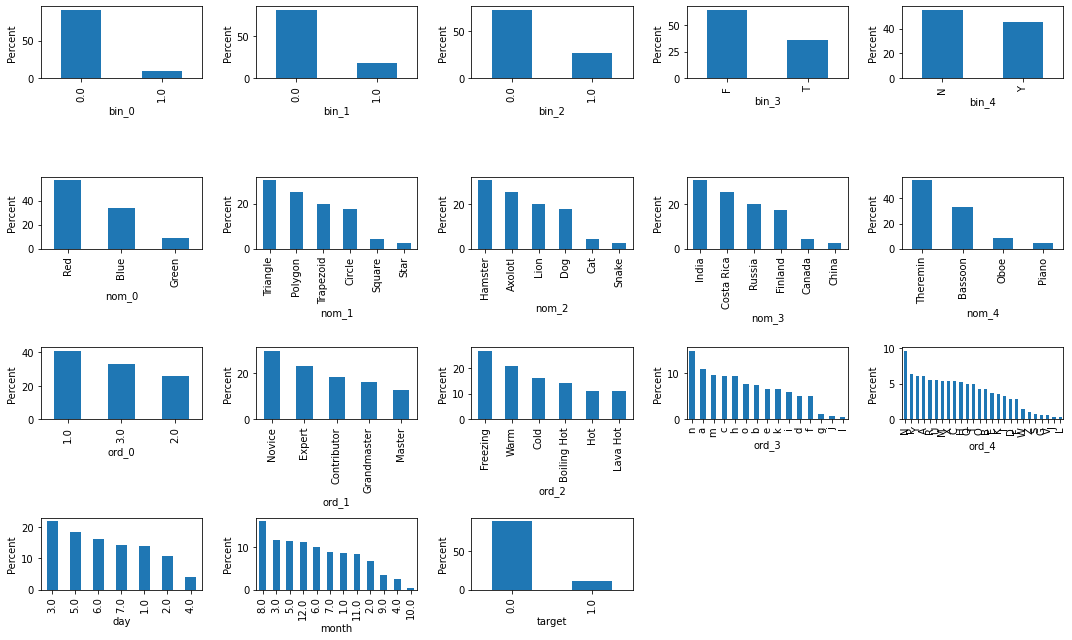

In [134]:
categorical = df.drop(columns = [f'nom_{i}' for i in range(5, 10)]+['ord_5']).columns

fig, axes = plt.subplots(4, 5, figsize=(15, 9))
axes = axes.flatten()

for i, col in enumerate(categorical):
    (100* df[col].value_counts() / len(df)).plot.bar(ax = axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percent')
    
for ax in axes[i+1:]:
    ax.axis('off')
    
plt.tight_layout()

In [137]:
df['bin_3'] = df['bin_3'].map({'F': 0, 'T': 1})
df['bin_4'] = df['bin_4'].map({'N': 0, 'Y': 1})

In [138]:
ord_1 = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_1 = dict(zip(ord_1, range(len(ord_1))))
df['ord_1'] = df['ord_1'].apply(lambda s: ord_1[s])

ord_2 = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']
ord_2 = dict(zip(ord_2, range(len(ord_2))))
df['ord_2'] = df['ord_2'].apply(lambda s: ord_2[s])

ord_3 = sorted(df['ord_3'].unique())
ord_3 = dict(zip(ord_3, range(len(ord_3))))
df['ord_3'] = df['ord_3'].apply(lambda s: ord_3[s])

ord_4 = sorted(df['ord_4'].unique())
ord_4 = dict(zip(ord_4, range(len(ord_4))))
df['ord_4'] = df['ord_4'].apply(lambda s: ord_4[s])

ord_5 = sorted(df['ord_5'].unique())
ord_5 = dict(zip(ord_5, range(len(ord_5))))
df['ord_5'] = df['ord_5'].apply(lambda s: ord_5[s])

In [139]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
nom_features = ['nom_' + str(i) for i in range(10)]
nom_dummy = encoder.fit_transform(df[nom_features])

df_non_nom = df.drop(columns = nom_features)

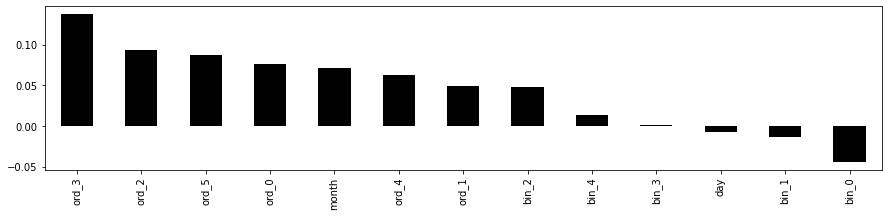

In [140]:
df_non_nom.corr()['target'].sort_values(ascending=False)[1:].plot.bar(figsize=(15,3), cmap='copper')
plt.show()

In [154]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = df_non_nom.drop(columns='target')
y = df_non_nom['target']

features = X.columns.values

Scaler = MinMaxScaler()
Scaler.fit(X)
X = Scaler.transform(X)

X = pd.DataFrame(X, columns = features)

In [155]:
from scipy import sparse

X = sparse.hstack(
    [
        sparse.csr_matrix(X),
        nom_dummy,
    ],
    format='csr'
)

In [156]:
X_test = X[len(train):]
X = X[:len(train)]
y = y.iloc[:len(train)]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [158]:
%%time
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

model_lr = LogisticRegression(C = 0.1, max_iter = 800, solver = 'liblinear')
model_lr.fit(X_train, y_train)
y_train_pred = model_lr.predict(X_train)
y_valid_pred = model_lr.predict(X_valid)

print("Training score: ", metrics.roc_auc_score(y_train, y_train_pred))
print("Validation score: ", metrics.roc_auc_score(y_valid, y_valid_pred))

Training score:  0.5882615121107321
Validation score:  0.5795210843374868
CPU times: user 13.9 s, sys: 72.7 ms, total: 14 s
Wall time: 14 s


In [130]:
%%time

model = XGBClassifier()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

print("Training score: ", metrics.roc_auc_score(y_train, y_train_pred))
print("Validation score: ", metrics.roc_auc_score(y_valid, y_valid_pred))

Training score:  0.572270984484907
Validation score:  0.558766460513905
CPU times: user 3min 33s, sys: 570 ms, total: 3min 34s
Wall time: 1min 43s


In [176]:
final_model = XGBClassifier()
final_model.fit(X, y)
print("Training score: ", metrics.roc_auc_score(y, final_model.predict_proba(X)[:, 1]))
y_test_pred = final_model.predict_proba(X_test)[:, 1]

Training score:  0.7899582420771672


In [177]:
output = pd.DataFrame({'id': ids, 'target': y_test_pred})

In [178]:
output.to_csv("Submission4.csv", index=False)